#### Your task is to design and implement an Image classifier using the deep learning techniques. <br>

•	Create custom models and one pretrained model;<br>
•	Train the custom model and Fine tune the pretrained model;<br>
•	Compare the performance of the custom models and the pretrained model;<br>
•	Discuss the impact of the fine tuning and transfer learning on the performance of your models and the outputs of your models;<br>
•	Improve your custom model design and reflect on the performance. <br>

The data set contains different images taken in different lighting conditions. For example, some are taken in broad daylight, and some are in the twilight. For simplicity, you have been given separate test set and train set, the images file type is PNG. They are of different sizes. <br>
Note:  you can resize all pictures to 28x28, but the more suitable size is 50X50 


In [1]:
import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET

from pathlib import Path
import os

from tensorflow.keras.applications import vgg16

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, optimizers
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image

In [2]:
#makes files in directory for images to be saved to
os.mkdir(Path('grayscale'))
os.mkdir(Path('aug_crosswalk'))
os.mkdir(Path('aug_stop'))
os.mkdir(Path('aug_trafficlight'))
os.mkdir(Path('new_path'))
os.mkdir(Path('new_path2'))

FileExistsError: [Errno 17] File exists: 'grayscale'

In [2]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()
 

In [3]:
#Loading the data¶

images_path = Path('images')
anno_path = Path('annotations')


In [4]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [6]:
def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot() # module implements a simple and efficient API for parsing and creating XML
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['Type'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [7]:
df_train = generate_train_df(anno_path)
df_train.head()

,filename,width,height,Type,xmin,ymin,xmax,ymax
0,images/road712.png,300,400,speedlimit,98,140,139,182
1,images/road706.png,300,400,speedlimit,136,92,177,135
2,images/road289.png,300,400,stop,61,140,146,227
3,images/road538.png,300,400,speedlimit,115,169,149,205
4,images/road510.png,300,400,speedlimit,89,201,133,245


In [8]:
df_train['Type'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: Type, dtype: int64

In [9]:
(df_train['Type'].value_counts()*100)/len(df_train['Type'])

speedlimit      74.344356
crosswalk       10.034208
stop             8.665906
trafficlight     6.955530
Name: Type, dtype: float64

In [10]:
#label encode target- creating dict data type the keys are the class value and the value are the num encoder 
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
# coding the class column with a numerical value 
df_train['class'] = df_train['Type'].apply(lambda x:  class_dict[x])

In [11]:
print(df_train.shape)
df_train.head()

(877, 9)


,filename,width,height,Type,xmin,ymin,xmax,ymax,class
0,images/road712.png,300,400,speedlimit,98,140,139,182,0
1,images/road706.png,300,400,speedlimit,136,92,177,135,0
2,images/road289.png,300,400,stop,61,140,146,227,1
3,images/road538.png,300,400,speedlimit,115,169,149,205,0
4,images/road510.png,300,400,speedlimit,89,201,133,245,0


In [12]:
df_train.width.unique()

array(['300', '320', '400', '267', '268', '321', '266', '395', '306',
       '254', '332'], dtype=object)

In [13]:
#Reading an image
def read_image(path):
    return cv2.imread(str(path))

In [14]:
def resize_image(read_path,write_path,sz):
    """Resize an image and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    #im_resized = cv2.resize(im, (224, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path,im_resized)
    return new_path


In [15]:
df_train1 = df_train.copy()

In [16]:
#Populating Training DF with new paths
new_paths = []
train_path_resized = Path('new_path')
print(type(train_path_resized))
for index, row in df_train1.iterrows():
    new_path = resize_image(row['filename'], train_path_resized,224)
    new_paths.append(new_path) 
print(type(row['filename']))
df_train1['new_path'] = new_paths


<class 'pathlib.PosixPath'>
<class 'pathlib.PosixPath'>


In [17]:
df_train1.filename = df_train1.new_path
df_train1.drop(columns=['new_path','width','height','xmin','ymin','xmax','ymax'], inplace=True)
df_train2=df_train1.copy()

In [18]:
df_train1

,filename,Type,class
0,new_path/road712.png,speedlimit,0
1,new_path/road706.png,speedlimit,0
2,new_path/road289.png,stop,1
3,new_path/road538.png,speedlimit,0
4,new_path/road510.png,speedlimit,0
...,...,...,...
872,new_path/road535.png,speedlimit,0
873,new_path/road284.png,speedlimit,0
874,new_path/road290.png,speedlimit,0
875,new_path/road723.png,speedlimit,0


In [19]:
def prepare_image(img):
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    print (img_array_expanded_dims)
    print (img_array_expanded_dims.shape)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
fname = df_train1[['filename']]
array_list=[]
for i in range(len(fname)):
    im=cv2.imread(str(fname.values[i][0])) #/255 #normalize
    array_list.append(prepare_image(im))

In [21]:
type(array_list)

list

In [22]:
# Normalizing the image arrays
X = np.array(array_list)
# Creating an empty tensor to store image arrays
tensor = np.zeros((X.shape[0],224,224,3))
# Iterating through image arrays to update tensor
for idx, i in enumerate(X):
    tensor[idx] = i
X=tensor
y = np.array(df_train1['class'])
y = tf.keras.utils.to_categorical(y, 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
type(X_train)

numpy.ndarray

(613, 224, 224, 3) (264, 224, 224, 3) (613, 4) (264, 4)
Epoch 1/10


2023-06-12 16:00:57.141916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 2.7651 - acc: 0.5318

2023-06-12 16:01:09.659447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 18s 4s/step - loss: 2.7651 - acc: 0.5318 - val_loss: 1.4287 - val_acc: 0.7348
Epoch 2/10
5/5 [==============================] - 16s 3s/step - loss: 0.6813 - acc: 0.8075 - val_loss: 0.6139 - val_acc: 0.7917
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 0.5572 - acc: 0.8059 - val_loss: 0.6674 - val_acc: 0.7803
Epoch 4/10
5/5 [==============================] - 16s 3s/step - loss: 0.2688 - acc: 0.9152 - val_loss: 0.5397 - val_acc: 0.8030
Epoch 5/10
5/5 [==============================] - 16s 3s/step - loss: 0.1910 - acc: 0.9543 - val_loss: 1.0969 - val_acc: 0.7235
Epoch 6/10
5/5 [==============================] - 16s 3s/step - loss: 0.1867 - acc: 0.9445 - val_loss: 0.4997 - val_acc: 0.8258
Epoch 7/10
5/5 [==============================] - 16s 3s/step - loss: 0.1781 - acc: 0.9429 - val_loss: 0.9685 - val_acc: 0.7500
Epoch 8/10
5/5 [==============================] - 16s 3s/step - loss: 0.1009 - acc: 0.9706 - val_loss: 0.4843 - val

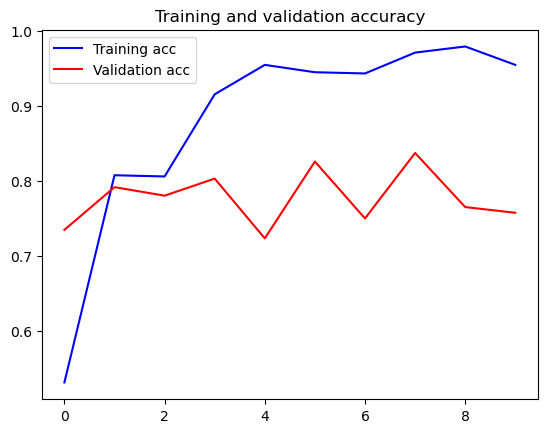

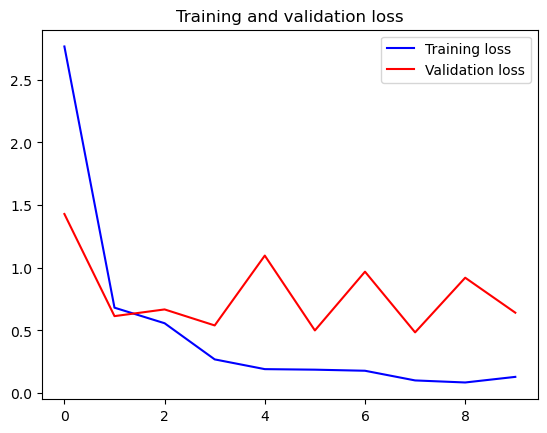

In [22]:
"""
      *****  VGG16 MODEL FOR TESTING PREPROCESSED IMAGES  *****
"""


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1)

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

In [28]:
pip install ultralytics

  Using cached ultralytics-8.0.116-py3-none-any.whl (599 kB)
  Using cached opencv_python-4.7.0.72-cp37-abi3-macosx_11_0_arm64.whl (32.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [42]:
from ultralytics import YOLO

In [43]:
model = YOLO('yolov8n.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [44]:
model.summary()

AttributeError: 'YOLO' object has no attribute 'summary'. See valid attributes below.

    YOLO (You Only Look Once) object detection model.

    Args:
        model (str, Path): Path to the model file to load or create.
        task (Any, optional): Task type for the YOLO model. Defaults to None.

    Attributes:
        predictor (Any): The predictor object.
        model (Any): The model object.
        trainer (Any): The trainer object.
        task (str): The type of model task.
        ckpt (Any): The checkpoint object if the model loaded from *.pt file.
        cfg (str): The model configuration if loaded from *.yaml file.
        ckpt_path (str): The checkpoint file path.
        overrides (dict): Overrides for the trainer object.
        metrics (Any): The data for metrics.

    Methods:
        __call__(source=None, stream=False, **kwargs):
            Alias for the predict method.
        _new(cfg:str, verbose:bool=True) -> None:
            Initializes a new model and infers the task type from the model definitions.
        _load(weights:str, task:str='') -> None:
            Initializes a new model and infers the task type from the model head.
        _check_is_pytorch_model() -> None:
            Raises TypeError if the model is not a PyTorch model.
        reset() -> None:
            Resets the model modules.
        info(verbose:bool=False) -> None:
            Logs the model info.
        fuse() -> None:
            Fuses the model for faster inference.
        predict(source=None, stream=False, **kwargs) -> List[ultralytics.yolo.engine.results.Results]:
            Performs prediction using the YOLO model.

    Returns:
        list(ultralytics.yolo.engine.results.Results): The prediction results.
    

## Image augmentation

In [22]:
#Image augmentation
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.15,
                         zoom_range=0.1, channel_shift_range=1.,
                         horizontal_flip=True)

In [27]:
df_train1.filename.loc[(df_train1.Type == 'stop')]

2      new_path/road289.png
10     new_path/road302.png
26     new_path/road673.png
40     new_path/road303.png
102    new_path/road270.png
               ...         
631     new_path/road62.png
634     new_path/road89.png
637    new_path/road185.png
749    new_path/road876.png
811    new_path/road278.png
Name: filename, Length: 76, dtype: object

In [ ]:
"""RUN ONCE! IMAGES ALREADY SAVED"""
signs = ['stop','crosswalk','trafficlight']
for element in signs:
    print(element)
    for im in df_train1.filename.loc[(df_train1.Type == element)]:        
        img = prepare_image(read_image(im))
        #below saves 10 aug images    
        aug_iter = gen.flow(img, save_to_dir='aug_'+str(element), save_prefix='aug-image-', save_format='png')
        aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [21]:
""" populating df with augmented image filepath """
cross_df = pd.DataFrame()
loc = 'aug_crosswalk'
directory = os.fsencode(loc)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename != None and 'aug-image' in filename:
        filepath = str(loc) +'/'+ filename
        filepath = pd.Series(filepath)
        cross_df=pd.concat([cross_df, filepath], ignore_index = True)
cross_df['Type'] = 'crosswalk'
cross_df['class'] = 2
cross_df.rename(columns = {0:'filename'}, inplace=True)
print(cross_df)


stop_df = pd.DataFrame()
loc = 'aug_stop'
directory = os.fsencode(loc)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename != None and 'aug-image' in filename:
        filepath = str(loc) +'/'+ filename
        filepath = pd.Series(filepath)
        stop_df=pd.concat([stop_df, filepath], ignore_index = True)
stop_df['Type'] = 'stop'
stop_df['class'] = 1
stop_df.rename(columns = {0:'filename'}, inplace=True)
print(stop_df)


trafficlight_df = pd.DataFrame()
loc = 'aug_trafficlight'
directory = os.fsencode(loc)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename != None and 'aug-image' in filename:
        filepath = str(loc) +'/'+ filename
        filepath = pd.Series(filepath)
        trafficlight_df=pd.concat([trafficlight_df, filepath], ignore_index = True)
trafficlight_df['Type'] = 'trafficlight'
trafficlight_df['class'] = 3
trafficlight_df.rename(columns = {0:'filename'}, inplace=True)
print(trafficlight_df)

                                filename       Type  class
0    aug_crosswalk/aug-image-_0_1337.png  crosswalk      2
1    aug_crosswalk/aug-image-_0_3508.png  crosswalk      2
2    aug_crosswalk/aug-image-_0_2170.png  crosswalk      2
3    aug_crosswalk/aug-image-_0_1492.png  crosswalk      2
4    aug_crosswalk/aug-image-_0_7785.png  crosswalk      2
..                                   ...        ...    ...
843  aug_crosswalk/aug-image-_0_6469.png  crosswalk      2
844  aug_crosswalk/aug-image-_0_5174.png  crosswalk      2
845  aug_crosswalk/aug-image-_0_7005.png  crosswalk      2
846  aug_crosswalk/aug-image-_0_2633.png  crosswalk      2
847  aug_crosswalk/aug-image-_0_9014.png  crosswalk      2

[848 rows x 3 columns]
                           filename  Type  class
0    aug_stop/aug-image-_0_1451.png  stop      1
1    aug_stop/aug-image-_0_5353.png  stop      1
2    aug_stop/aug-image-_0_7578.png  stop      1
3    aug_stop/aug-image-_0_1848.png  stop      1
4    aug_stop/aug-image

In [22]:
df_train2 = pd.concat([df_train2, cross_df, stop_df, trafficlight_df], ignore_index=True)
df_train2.reset_index(drop=True, inplace=True)
df_train2

,filename,Type,class
0,new_path/road712.png,speedlimit,0
1,new_path/road706.png,speedlimit,0
2,new_path/road289.png,stop,1
3,new_path/road538.png,speedlimit,0
4,new_path/road510.png,speedlimit,0
...,...,...,...
3028,aug_trafficlight/aug-image-_0_3288.png,trafficlight,3
3029,aug_trafficlight/aug-image-_0_5606.png,trafficlight,3
3030,aug_trafficlight/aug-image-_0_9766.png,trafficlight,3
3031,aug_trafficlight/aug-image-_0_3539.png,trafficlight,3


In [ ]:
fname2 = df_train2[['filename']]
array_list2=[]
for i in range(len(fname2)):
    im=cv2.imread(str(fname2.values[i][0])) #/255 #normalize
    array_list2.append(prepare_image(im))

(2123, 224, 224, 3) (910, 224, 224, 3) (2123, 4) (910, 4)
Epoch 1/10


2023-01-09 09:04:22.875179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.9406 - acc: 0.5101

2023-01-09 09:05:05.015556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 59s 3s/step - loss: 1.9406 - acc: 0.5101 - val_loss: 0.6609 - val_acc: 0.7242
Epoch 2/10
17/17 [==============================] - 55s 3s/step - loss: 0.5484 - acc: 0.8017 - val_loss: 0.3728 - val_acc: 0.8758
Epoch 3/10
17/17 [==============================] - 55s 3s/step - loss: 0.3324 - acc: 0.8799 - val_loss: 0.2946 - val_acc: 0.8912
Epoch 4/10
17/17 [==============================] - 54s 3s/step - loss: 0.1973 - acc: 0.9350 - val_loss: 0.3064 - val_acc: 0.8835
Epoch 5/10
17/17 [==============================] - 54s 3s/step - loss: 0.2224 - acc: 0.9364 - val_loss: 0.1663 - val_acc: 0.9418
Epoch 6/10
17/17 [==============================] - 54s 3s/step - loss: 0.2945 - acc: 0.9270 - val_loss: 0.1478 - val_acc: 0.9462
Epoch 7/10
17/17 [==============================] - 54s 3s/step - loss: 0.0392 - acc: 0.9934 - val_loss: 0.1327 - val_acc: 0.9560
Epoch 8/10
17/17 [==============================] - 54s 3s/step - loss: 0.2310 - acc: 0.9487 - val_lo

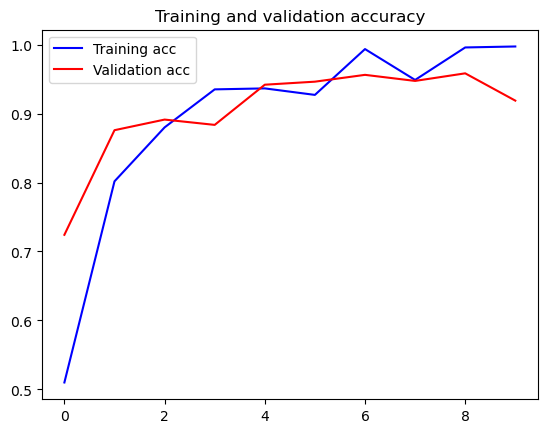

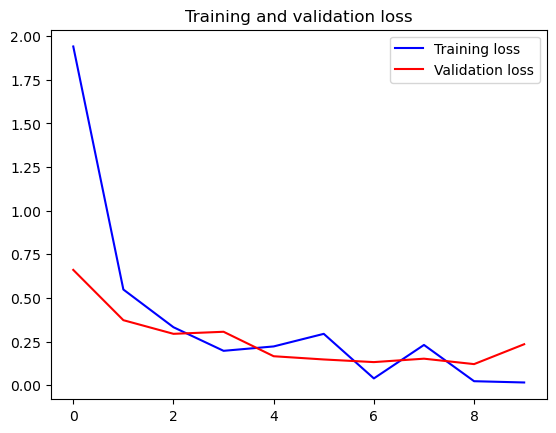

In [31]:
"""
      *****  VGG16 MODEL FOR TESTING PREPROCESSED IMAGES  *****
"""

# Normalizing the image arrays
X = np.array(array_list2)
# Creating an empty tensor to store image arrays
tensor = np.zeros((X.shape[0],224,224,3))
# Iterating through image arrays to update tensor
for idx, i in enumerate(X):
    tensor[idx] = i
X=tensor
y = np.array(df_train2['class'])
y = tf.keras.utils.to_categorical(y, 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

# Rescaling 50x50

In [38]:
#Populating Training DF with new paths
new_paths = []
train_path_resized = Path('new_path2')
print(type(train_path_resized))
for index, row in df_train2.iterrows():
    #print(type(row['filename']))
    new_path = resize_image(Path(row['filename']), train_path_resized,50)
    new_paths.append(new_path)   
df_train2['new_path'] = new_paths
df_train2.head(2)

<class 'pathlib.PosixPath'>


,filename,Type,class,new_path
0,new_path/road712.png,speedlimit,0,new_path2/road712.png
1,new_path/road706.png,speedlimit,0,new_path2/road706.png


In [ ]:
fname3 = df_train2[['new_path']]
array_list3=[]
for i in range(len(fname3)):
    im=cv2.imread(str(fname3.values[i][0])) #/255 #normalize
    array_list3.append(prepare_image(im))

(2123, 50, 50, 3) (910, 50, 50, 3) (2123, 4) (910, 4)
Epoch 1/10


2023-01-09 09:20:36.867887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3024 - acc: 0.3952

2023-01-09 09:20:39.346226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 4s 179ms/step - loss: 1.3024 - acc: 0.3952 - val_loss: 1.1332 - val_acc: 0.5868
Epoch 2/10
17/17 [==============================] - 3s 164ms/step - loss: 1.1202 - acc: 0.5417 - val_loss: 1.0336 - val_acc: 0.6033
Epoch 3/10
17/17 [==============================] - 3s 163ms/step - loss: 1.0169 - acc: 0.6039 - val_loss: 0.9529 - val_acc: 0.6549
Epoch 4/10
17/17 [==============================] - 3s 166ms/step - loss: 0.9349 - acc: 0.6354 - val_loss: 0.9070 - val_acc: 0.6560
Epoch 5/10
17/17 [==============================] - 3s 164ms/step - loss: 0.8743 - acc: 0.6726 - val_loss: 0.8580 - val_acc: 0.6901
Epoch 6/10
17/17 [==============================] - 3s 164ms/step - loss: 0.8223 - acc: 0.6821 - val_loss: 0.8328 - val_acc: 0.6945
Epoch 7/10
17/17 [==============================] - 3s 164ms/step - loss: 0.7858 - acc: 0.7094 - val_loss: 0.8059 - val_acc: 0.7055
Epoch 8/10
17/17 [==============================] - 3s 164ms/step - loss: 0.7611 - acc:

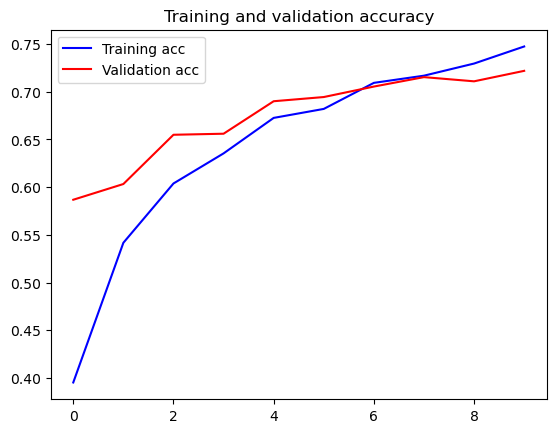

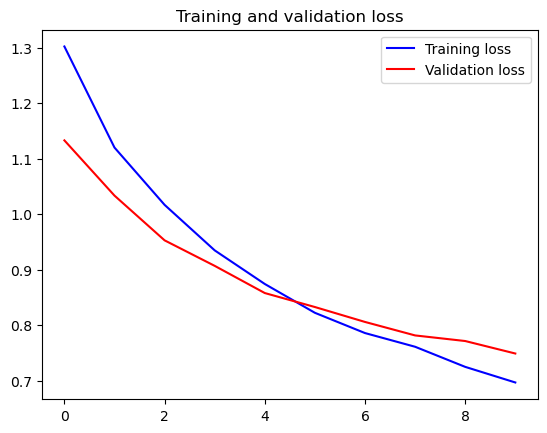

In [40]:
"""
      *****  VGG16 MODEL FOR TESTING PREPROCESSED IMAGES  *****
"""

# Normalizing the image arrays
X = np.array(array_list3)
# Creating an empty tensor to store image arrays
tensor = np.zeros((X.shape[0],50,50,3))
# Iterating through image arrays to update tensor
for idx, i in enumerate(X):
    tensor[idx] = i
X=tensor
y = np.array(df_train2['class'])
y = tf.keras.utils.to_categorical(y, 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(50, 50, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

## Greyscale 

In [97]:
def grayscale(read_path,write_path):
    gray_image = cv2.imread(str(read_path),0)
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path,gray_image)
    return new_path

In [99]:
#Populating Training DF with new paths
new_paths = []
train_path_resized = Path('grayscale')
print(type(train_path_resized))
for index, row in df_train2.iterrows():
    new_path = grayscale(Path(row['filename']), train_path_resized)
    new_paths.append(new_path) 
print(type(row['filename']))
df_train2['grayscale'] = new_paths
df_train2.head(2)

<class 'pathlib.PosixPath'>
<class 'str'>


,filename,Type,class,new_path,grayscale
0,new_path/road712.png,speedlimit,0,new_path2/road712.png,grayscale/road712.png
1,new_path/road706.png,speedlimit,0,new_path2/road706.png,grayscale/road706.png


In [ ]:
fname4 = df_train2[['grayscale']]
array_list4=[]
for i in range(len(fname4)):
    im=cv2.imread(str(fname4.values[i][0])) #/255 #normalize
    array_list4.append(prepare_image(im))

(2123, 224, 224, 3) (910, 224, 224, 3) (2123, 4) (910, 4)
Epoch 1/10


2023-01-09 10:44:07.088910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 2.2430 - acc: 0.4611

2023-01-09 10:44:49.087453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 62s 4s/step - loss: 2.2430 - acc: 0.4611 - val_loss: 0.8221 - val_acc: 0.7055
Epoch 2/10
17/17 [==============================] - 56s 3s/step - loss: 0.8086 - acc: 0.6952 - val_loss: 0.7773 - val_acc: 0.7077
Epoch 3/10
17/17 [==============================] - 55s 3s/step - loss: 0.6238 - acc: 0.7720 - val_loss: 0.5974 - val_acc: 0.8154
Epoch 4/10
17/17 [==============================] - 56s 3s/step - loss: 0.4651 - acc: 0.8375 - val_loss: 1.0530 - val_acc: 0.6176
Epoch 5/10
17/17 [==============================] - 54s 3s/step - loss: 0.3968 - acc: 0.8629 - val_loss: 0.4918 - val_acc: 0.8582
Epoch 6/10
17/17 [==============================] - 54s 3s/step - loss: 0.3969 - acc: 0.8658 - val_loss: 0.4781 - val_acc: 0.8374
Epoch 7/10
17/17 [==============================] - 54s 3s/step - loss: 0.2123 - acc: 0.9359 - val_loss: 0.8699 - val_acc: 0.7110
Epoch 8/10
17/17 [==============================] - 55s 3s/step - loss: 0.2529 - acc: 0.9124 - val_lo

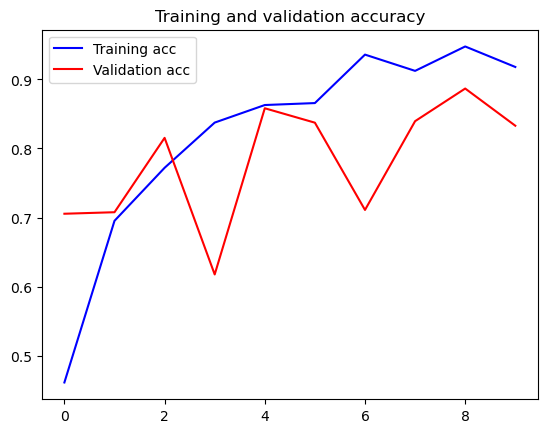

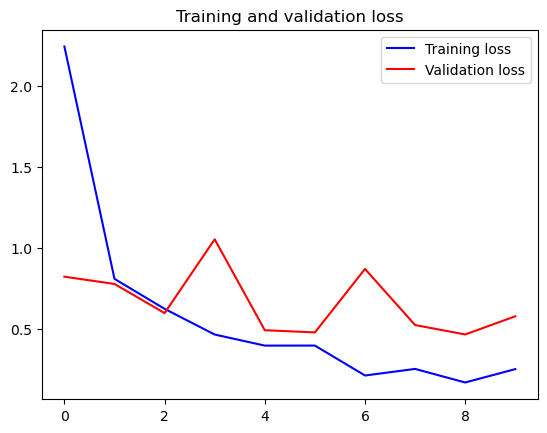

In [106]:
"""
      *****  VGG16 MODEL FOR TESTING PREPROCESSED IMAGES  *****
"""

# Normalizing the image arrays
X = np.array(array_list4)
# Creating an empty tensor to store image arrays
tensor = np.zeros((X.shape[0],224,224,3))
# Iterating through image arrays to update tensor
for idx, i in enumerate(X):
    tensor[idx] = i
X=tensor
y = np.array(df_train2['class'])
y = tf.keras.utils.to_categorical(y, 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

## Variable preperation

In [24]:
# Normalizing the image arrays
X = np.array(array_list2)
# Creating an empty tensor to store image arrays
tensor = np.zeros((X.shape[0],224,224,3))
# Iterating through image arrays to update tensor
for idx, i in enumerate(X):
    tensor[idx] = i
# Checking the tensor shape
tensor.shape

(3033, 224, 224, 3)

In [25]:
#X=np.array(array_list)
X=tensor
y = np.array(df_train2['class'])
y = tf.keras.utils.to_categorical(y, 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2123, 224, 224, 3) (910, 224, 224, 3) (2123, 4) (910, 4)


## Building net - VGG16


In [113]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

553467096/553467096 [==============================] - 67s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [110]:
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [111]:
# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

In [112]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 40,409,924
Trainable params: 25,695,236
Non-trainable params: 14,714,688
_________________________________________________________________


#### Epoch

Epoch 1/50


2023-01-09 13:16:17.009104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 2.0141 - acc: 0.5374

2023-01-09 13:16:59.713086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 60s 4s/step - loss: 2.0141 - acc: 0.5374 - val_loss: 0.4705 - val_acc: 0.8484
Epoch 2/50
17/17 [==============================] - 61s 4s/step - loss: 0.4944 - acc: 0.8172 - val_loss: 0.4839 - val_acc: 0.8044
Epoch 3/50
17/17 [==============================] - 66s 4s/step - loss: 0.3466 - acc: 0.8766 - val_loss: 0.4493 - val_acc: 0.8209
Epoch 4/50
17/17 [==============================] - 61s 4s/step - loss: 0.2292 - acc: 0.9256 - val_loss: 0.2004 - val_acc: 0.9396
Epoch 5/50
17/17 [==============================] - 56s 3s/step - loss: 0.1912 - acc: 0.9482 - val_loss: 0.2322 - val_acc: 0.9033
Epoch 6/50
17/17 [==============================] - 55s 3s/step - loss: 0.1900 - acc: 0.9491 - val_loss: 0.1653 - val_acc: 0.9407
Epoch 7/50
17/17 [==============================] - 55s 3s/step - loss: 0.0700 - acc: 0.9826 - val_loss: 1.3005 - val_acc: 0.7407
Epoch 8/50
17/17 [==============================] - 54s 3s/step - loss: 0.0702 - acc: 0.9868 - val_lo

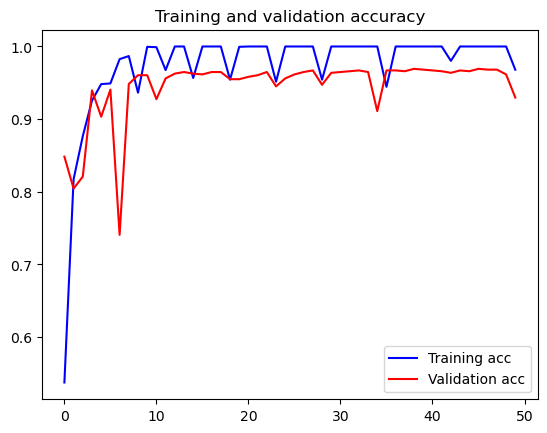

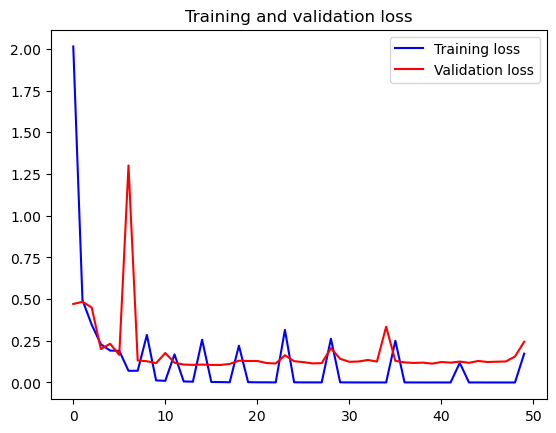

In [114]:
""" ***** 50 EPOCH TEST ***** """
 
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=50, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

#### batch size

Epoch 1/10


2023-01-09 14:28:40.648420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 14:29:20.569882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


34/34 - 56s - loss: 1.3616 - acc: 0.6123 - val_loss: 0.8630 - val_acc: 0.6791 - 56s/epoch - 2s/step
Epoch 2/10
34/34 - 54s - loss: 0.3952 - acc: 0.8507 - val_loss: 0.3139 - val_acc: 0.8758 - 54s/epoch - 2s/step
Epoch 3/10
34/34 - 54s - loss: 0.2418 - acc: 0.9195 - val_loss: 0.2446 - val_acc: 0.9154 - 54s/epoch - 2s/step
Epoch 4/10
34/34 - 53s - loss: 0.1477 - acc: 0.9425 - val_loss: 0.3111 - val_acc: 0.8791 - 53s/epoch - 2s/step
Epoch 5/10
34/34 - 53s - loss: 0.1415 - acc: 0.9562 - val_loss: 0.3344 - val_acc: 0.8857 - 53s/epoch - 2s/step
Epoch 6/10
34/34 - 53s - loss: 0.0402 - acc: 0.9887 - val_loss: 0.3697 - val_acc: 0.8802 - 53s/epoch - 2s/step
Epoch 7/10
34/34 - 53s - loss: 0.0486 - acc: 0.9840 - val_loss: 0.1706 - val_acc: 0.9484 - 53s/epoch - 2s/step
Epoch 8/10
34/34 - 54s - loss: 0.0585 - acc: 0.9840 - val_loss: 0.1214 - val_acc: 0.9637 - 54s/epoch - 2s/step
Epoch 9/10
34/34 - 54s - loss: 0.0305 - acc: 0.9929 - val_loss: 0.5046 - val_acc: 0.8363 - 54s/epoch - 2s/step
Epoch 10/10


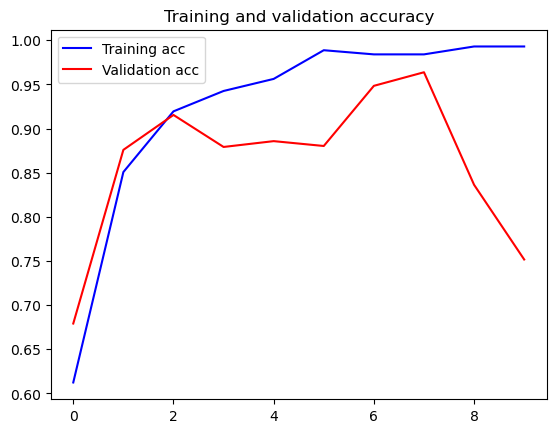

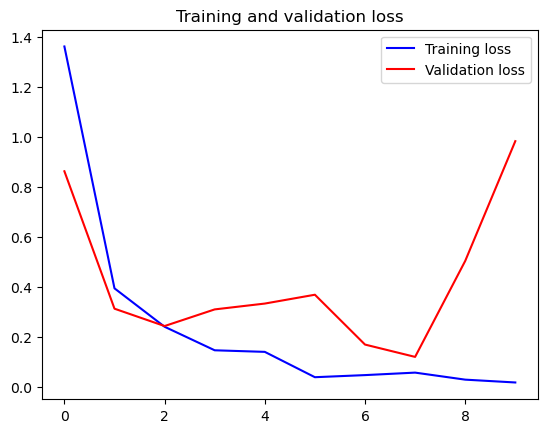

In [115]:
""" ***** different batch size 64 ***** """
 
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=64, validation_data=(X_test, y_test), 
                  epochs=10, verbose=2) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

2023-01-09 14:55:49.733686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-09 14:55:49.734340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Epoch 1/10


2023-01-09 14:55:52.767819: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-09 14:55:53.200807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 2.6817 - acc: 0.3500

2023-01-09 14:56:38.969327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 63s 7s/step - loss: 2.6817 - acc: 0.3500 - val_loss: 0.6618 - val_acc: 0.7593
Epoch 2/10
9/9 [==============================] - 58s 7s/step - loss: 0.6433 - acc: 0.7508 - val_loss: 0.5181 - val_acc: 0.8132
Epoch 3/10
9/9 [==============================] - 57s 6s/step - loss: 0.5559 - acc: 0.7833 - val_loss: 0.6128 - val_acc: 0.7538
Epoch 4/10
9/9 [==============================] - 57s 7s/step - loss: 0.3252 - acc: 0.8902 - val_loss: 0.6452 - val_acc: 0.7538
Epoch 5/10
9/9 [==============================] - 57s 6s/step - loss: 0.3307 - acc: 0.8738 - val_loss: 0.4521 - val_acc: 0.8198
Epoch 6/10
9/9 [==============================] - 57s 7s/step - loss: 0.1982 - acc: 0.9336 - val_loss: 0.2434 - val_acc: 0.9165
Epoch 7/10
9/9 [==============================] - 57s 7s/step - loss: 0.2870 - acc: 0.8912 - val_loss: 0.4332 - val_acc: 0.8319
Epoch 8/10
9/9 [==============================] - 57s 7s/step - loss: 0.1188 - acc: 0.9609 - val_loss: 0.2272 - val

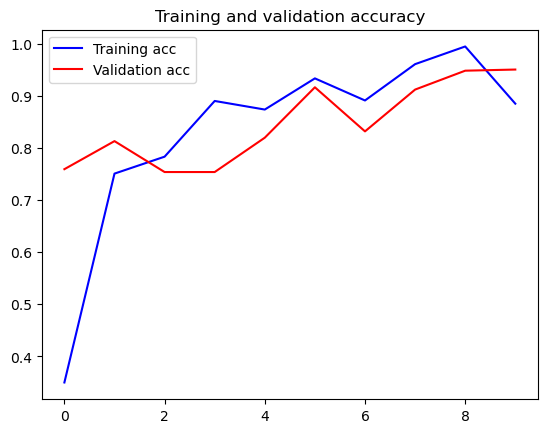

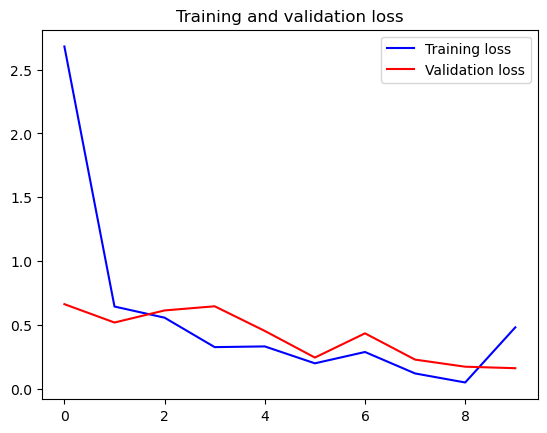

In [26]:
""" ***** different batch size 256 ***** """
 
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=256, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

#### Learning rate

Epoch 1/10


2023-01-09 15:39:01.099398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 14.5809 - acc: 0.4395

2023-01-09 15:39:43.267571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 59s 3s/step - loss: 14.5809 - acc: 0.4395 - val_loss: 1.1506 - val_acc: 0.6879
Epoch 2/10
17/17 [==============================] - 54s 3s/step - loss: 0.8827 - acc: 0.7197 - val_loss: 0.6573 - val_acc: 0.7923
Epoch 3/10
17/17 [==============================] - 54s 3s/step - loss: 0.5900 - acc: 0.7909 - val_loss: 0.5534 - val_acc: 0.8055
Epoch 4/10
17/17 [==============================] - 54s 3s/step - loss: 0.4462 - acc: 0.8431 - val_loss: 0.3340 - val_acc: 0.8747
Epoch 5/10
17/17 [==============================] - 54s 3s/step - loss: 0.4529 - acc: 0.8512 - val_loss: 1.2837 - val_acc: 0.7088
Epoch 6/10
17/17 [==============================] - 54s 3s/step - loss: 0.3927 - acc: 0.8724 - val_loss: 0.1768 - val_acc: 0.9330
Epoch 7/10
17/17 [==============================] - 55s 3s/step - loss: 0.3948 - acc: 0.9114 - val_loss: 4.3348 - val_acc: 0.5385
Epoch 8/10
17/17 [==============================] - 54s 3s/step - loss: 0.5784 - acc: 0.9044 - val_l

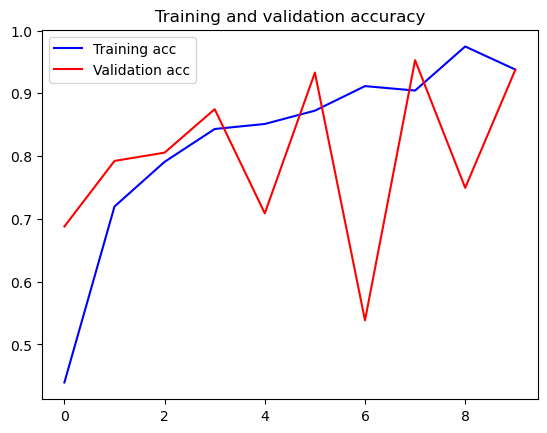

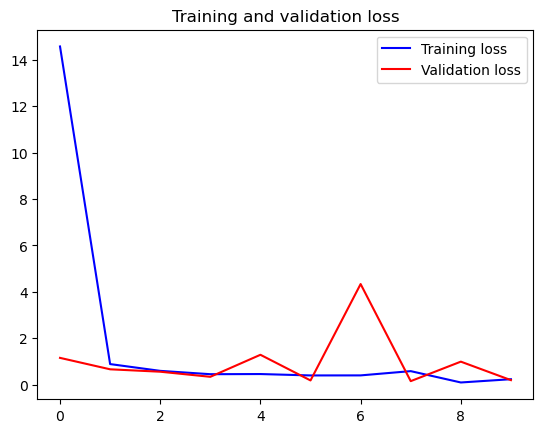

In [27]:
""" ***** different learning rate ***** """
 
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

Epoch 1/10


2023-01-09 15:56:06.977329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3416 - acc: 0.4079

2023-01-09 15:56:49.341346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 59s 3s/step - loss: 1.3416 - acc: 0.4079 - val_loss: 0.8966 - val_acc: 0.7297
Epoch 2/10
17/17 [==============================] - 55s 3s/step - loss: 0.8909 - acc: 0.6552 - val_loss: 0.7006 - val_acc: 0.8011
Epoch 3/10
17/17 [==============================] - 55s 3s/step - loss: 0.6798 - acc: 0.7640 - val_loss: 0.5729 - val_acc: 0.8473
Epoch 4/10
17/17 [==============================] - 55s 3s/step - loss: 0.5438 - acc: 0.8318 - val_loss: 0.4974 - val_acc: 0.8626
Epoch 5/10
17/17 [==============================] - 54s 3s/step - loss: 0.4339 - acc: 0.8728 - val_loss: 0.4396 - val_acc: 0.8703
Epoch 6/10
17/17 [==============================] - 55s 3s/step - loss: 0.3635 - acc: 0.8950 - val_loss: 0.3786 - val_acc: 0.8879
Epoch 7/10
17/17 [==============================] - 55s 3s/step - loss: 0.3081 - acc: 0.9185 - val_loss: 0.3410 - val_acc: 0.8967
Epoch 8/10
17/17 [==============================] - 54s 3s/step - loss: 0.2457 - acc: 0.9468 - val_lo

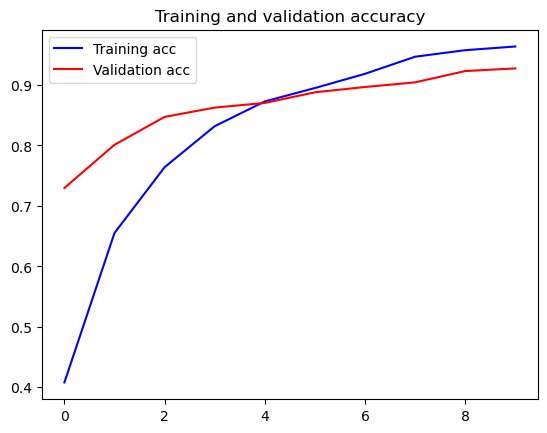

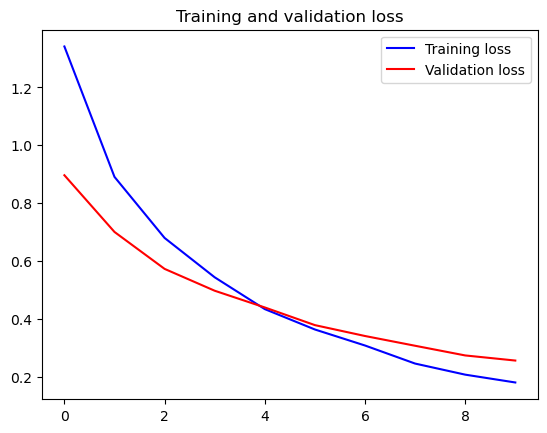

In [28]:
""" ***** different learning rate ***** """
 
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

#### activation function

Epoch 1/10


2023-01-09 16:27:46.127848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 2.4429 - acc: 0.5379

2023-01-09 16:28:28.073816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 59s 3s/step - loss: 2.4429 - acc: 0.5379 - val_loss: 0.6203 - val_acc: 0.7813
Epoch 2/10
17/17 [==============================] - 55s 3s/step - loss: 0.6428 - acc: 0.7673 - val_loss: 1.2474 - val_acc: 0.6681
Epoch 3/10
17/17 [==============================] - 56s 3s/step - loss: 0.3446 - acc: 0.8874 - val_loss: 1.2199 - val_acc: 0.6923
Epoch 4/10
17/17 [==============================] - 55s 3s/step - loss: 0.3262 - acc: 0.9129 - val_loss: 0.1886 - val_acc: 0.9374
Epoch 5/10
17/17 [==============================] - 55s 3s/step - loss: 0.4306 - acc: 0.8879 - val_loss: 0.1746 - val_acc: 0.9407
Epoch 6/10
17/17 [==============================] - 57s 3s/step - loss: 0.0530 - acc: 0.9854 - val_loss: 0.4919 - val_acc: 0.8220
Epoch 7/10
17/17 [==============================] - 56s 3s/step - loss: 0.3602 - acc: 0.9034 - val_loss: 0.1773 - val_acc: 0.9352
Epoch 8/10
17/17 [==============================] - 55s 3s/step - loss: 0.0211 - acc: 0.9972 - val_lo

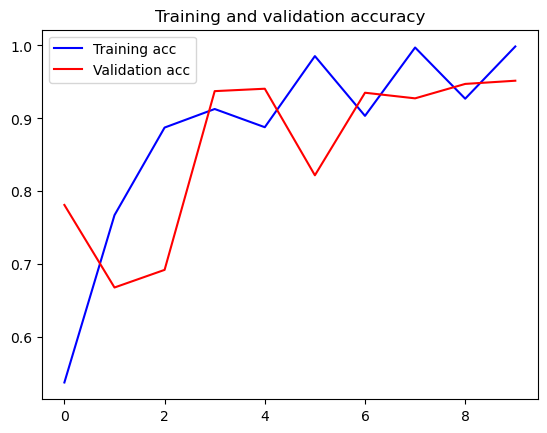

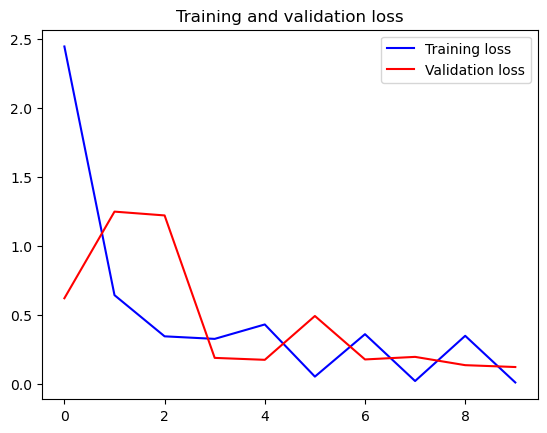

In [29]:
""" ***** different activation function ***** """
 
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

Epoch 1/10


2023-01-09 16:38:31.095121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3102 - acc: 0.5243

2023-01-09 16:39:12.687124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 58s 3s/step - loss: 1.3102 - acc: 0.5243 - val_loss: 0.6491 - val_acc: 0.7560
Epoch 2/10
17/17 [==============================] - 54s 3s/step - loss: 0.5257 - acc: 0.8210 - val_loss: 0.3952 - val_acc: 0.8802
Epoch 3/10
17/17 [==============================] - 54s 3s/step - loss: 0.3653 - acc: 0.8794 - val_loss: 0.3218 - val_acc: 0.9033
Epoch 4/10
17/17 [==============================] - 54s 3s/step - loss: 0.2310 - acc: 0.9425 - val_loss: 0.3211 - val_acc: 0.8857
Epoch 5/10
17/17 [==============================] - 55s 3s/step - loss: 0.2206 - acc: 0.9331 - val_loss: 0.2103 - val_acc: 0.9407
Epoch 6/10
17/17 [==============================] - 54s 3s/step - loss: 0.1115 - acc: 0.9764 - val_loss: 0.2572 - val_acc: 0.9154
Epoch 7/10
17/17 [==============================] - 55s 3s/step - loss: 0.1515 - acc: 0.9538 - val_loss: 0.1721 - val_acc: 0.9451
Epoch 8/10
17/17 [==============================] - 56s 3s/step - loss: 0.0573 - acc: 0.9953 - val_lo

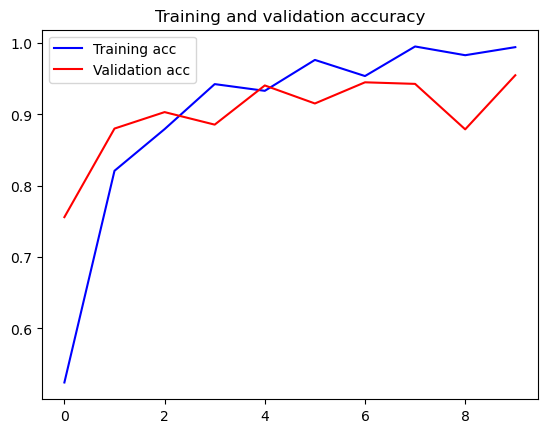

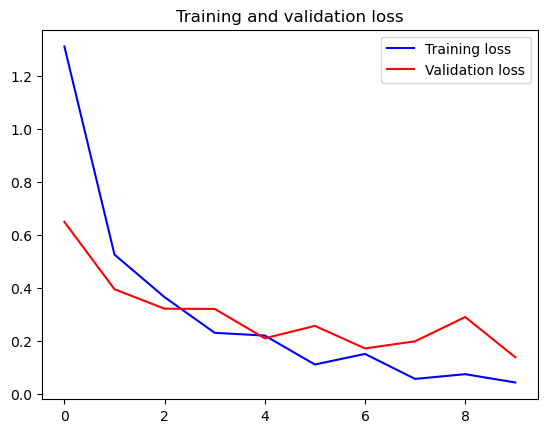

In [30]:
""" ***** different activation function ***** """
 
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

Epoch 1/10


2023-01-09 16:48:25.083240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3735 - acc: 0.4060

2023-01-09 16:49:07.859763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 60s 3s/step - loss: 1.3735 - acc: 0.4060 - val_loss: 1.3626 - val_acc: 0.5330
Epoch 2/10
17/17 [==============================] - 58s 3s/step - loss: 1.3505 - acc: 0.5577 - val_loss: 1.3456 - val_acc: 0.6571
Epoch 3/10
17/17 [==============================] - 55s 3s/step - loss: 1.3360 - acc: 0.5916 - val_loss: 1.3360 - val_acc: 0.6681
Epoch 4/10
17/17 [==============================] - 55s 3s/step - loss: 1.3254 - acc: 0.5817 - val_loss: 1.3284 - val_acc: 0.7132
Epoch 5/10
17/17 [==============================] - 54s 3s/step - loss: 1.3171 - acc: 0.6020 - val_loss: 1.3232 - val_acc: 0.6967
Epoch 6/10
17/17 [==============================] - 55s 3s/step - loss: 1.3152 - acc: 0.5761 - val_loss: 1.3187 - val_acc: 0.7890
Epoch 7/10
17/17 [==============================] - 55s 3s/step - loss: 1.3052 - acc: 0.6039 - val_loss: 1.3152 - val_acc: 0.7791
Epoch 8/10
17/17 [==============================] - 55s 3s/step - loss: 1.2993 - acc: 0.6274 - val_lo

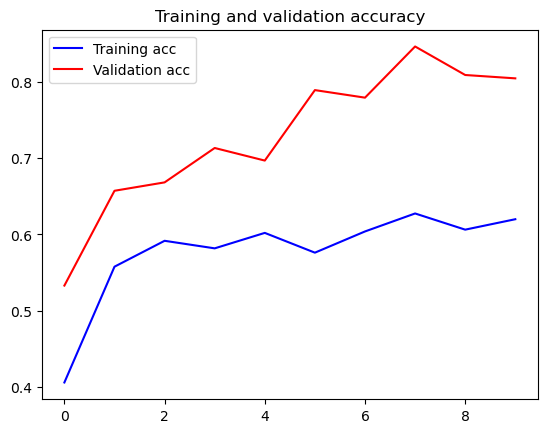

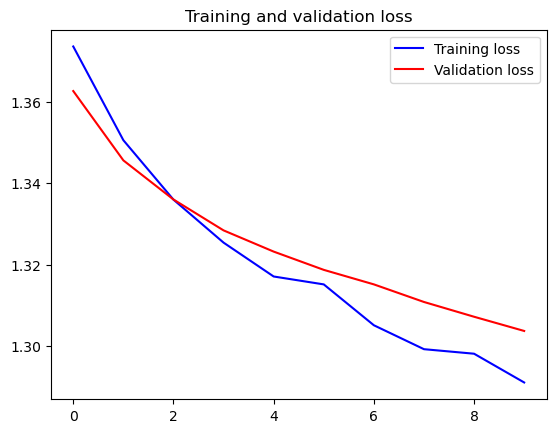

In [31]:
""" ***** different activation function ***** """
 
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=10, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

Epoch 1/15


2023-01-09 17:10:41.122881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3005 - acc: 0.4451

2023-01-09 17:11:23.354707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 61s 3s/step - loss: 1.3005 - acc: 0.4451 - val_loss: 0.9097 - val_acc: 0.6187
Epoch 2/15
17/17 [==============================] - 55s 3s/step - loss: 0.8064 - acc: 0.6910 - val_loss: 0.6481 - val_acc: 0.7945
Epoch 3/15
17/17 [==============================] - 55s 3s/step - loss: 0.5746 - acc: 0.8158 - val_loss: 0.5299 - val_acc: 0.8462
Epoch 4/15
17/17 [==============================] - 54s 3s/step - loss: 0.4417 - acc: 0.8832 - val_loss: 0.4483 - val_acc: 0.8582
Epoch 5/15
17/17 [==============================] - 54s 3s/step - loss: 0.3484 - acc: 0.9063 - val_loss: 0.3734 - val_acc: 0.8846
Epoch 6/15
17/17 [==============================] - 55s 3s/step - loss: 0.2890 - acc: 0.9237 - val_loss: 0.3519 - val_acc: 0.8912
Epoch 7/15
17/17 [==============================] - 55s 3s/step - loss: 0.2245 - acc: 0.9496 - val_loss: 0.2986 - val_acc: 0.9077
Epoch 8/15
17/17 [==============================] - 55s 3s/step - loss: 0.1860 - acc: 0.9623 - val_lo

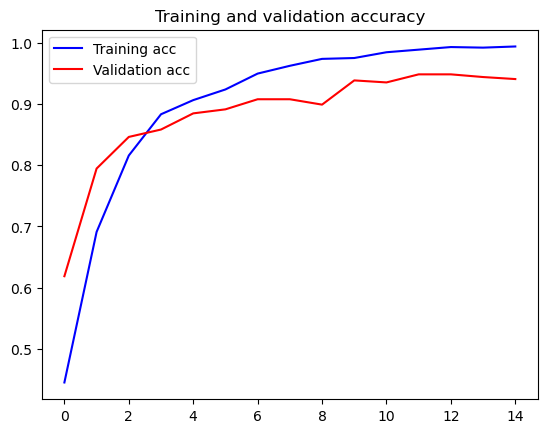

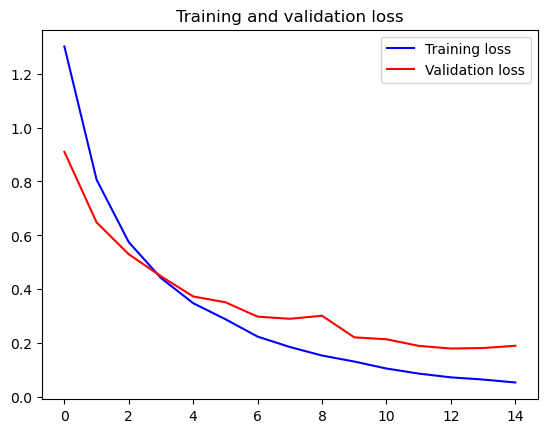

In [32]:
""" ***** combining bests ***** """
 
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history=model.fit(X_train, y_train, 
                  batch_size=128, validation_data=(X_test, y_test), 
                  epochs=15, verbose=1) #for more info

model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False)

visualize_results(history)

# Custom model

In [35]:
custom_model = Sequential([ 
                            Conv2D(12,3, input_shape=(224, 224, 3), activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Flatten(),
                            Dropout(0.5),
                            Dense(1024, activation='relu'),
                            Dense(64, activation='relu'),
                            Dense(4, activation='softmax')
                            ])
# Configure the model for training
custom_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
custom_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 12)      336       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 12)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 12)      1308      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 12)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 12)        1308      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 12)      

Fit model on training data
Epoch 1/10


2023-01-09 17:42:50.435054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3606 - acc: 0.3000

2023-01-09 17:42:56.340615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 8s 385ms/step - loss: 1.3606 - acc: 0.3000 - val_loss: 1.3500 - val_acc: 0.3000
Epoch 2/10
17/17 [==============================] - 5s 298ms/step - loss: 1.3331 - acc: 0.3212 - val_loss: 1.3261 - val_acc: 0.3000
Epoch 3/10
17/17 [==============================] - 5s 290ms/step - loss: 1.3061 - acc: 0.3208 - val_loss: 1.2935 - val_acc: 0.3582
Epoch 4/10
17/17 [==============================] - 5s 282ms/step - loss: 1.2717 - acc: 0.3646 - val_loss: 1.2502 - val_acc: 0.3890
Epoch 5/10
17/17 [==============================] - 5s 284ms/step - loss: 1.2291 - acc: 0.4310 - val_loss: 1.1969 - val_acc: 0.5088
Epoch 6/10
17/17 [==============================] - 5s 316ms/step - loss: 1.1842 - acc: 0.4635 - val_loss: 1.1456 - val_acc: 0.5121
Epoch 7/10
17/17 [==============================] - 5s 295ms/step - loss: 1.1439 - acc: 0.4889 - val_loss: 1.1056 - val_acc: 0.5418
Epoch 8/10
17/17 [==============================] - 5s 290ms/step - loss: 1.1080 - acc:

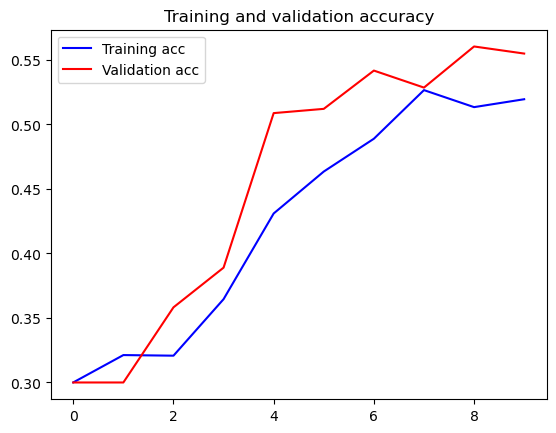

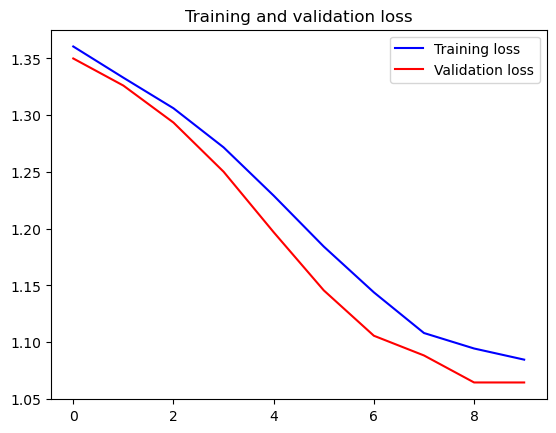

In [36]:
print("Fit model on training data")
history=custom_model.fit(X_train, y_train, batch_size=128,
                         validation_data=(X_test, y_test), 
                         epochs=10, verbose=1) #for more info
custom_model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    return_dict=False
    )
visualize_results(history)

Fit model on training data
Epoch 1/10


2023-01-09 20:36:59.867572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3109 - acc: 0.3618

2023-01-09 20:37:07.616303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 10s 461ms/step - loss: 1.3109 - acc: 0.3618 - val_loss: 1.2610 - val_acc: 0.3978
Epoch 2/10
17/17 [==============================] - 6s 355ms/step - loss: 1.2376 - acc: 0.4206 - val_loss: 1.1934 - val_acc: 0.4253
Epoch 3/10
17/17 [==============================] - 6s 346ms/step - loss: 1.1822 - acc: 0.4706 - val_loss: 1.1473 - val_acc: 0.4846
Epoch 4/10
17/17 [==============================] - 6s 352ms/step - loss: 1.1332 - acc: 0.5181 - val_loss: 1.1076 - val_acc: 0.5407
Epoch 5/10
17/17 [==============================] - 6s 348ms/step - loss: 1.0913 - acc: 0.5539 - val_loss: 1.0792 - val_acc: 0.5516
Epoch 6/10
17/17 [==============================] - 6s 335ms/step - loss: 1.0481 - acc: 0.5770 - val_loss: 1.0291 - val_acc: 0.5956
Epoch 7/10
17/17 [==============================] - 6s 348ms/step - loss: 1.0192 - acc: 0.5827 - val_loss: 1.0047 - val_acc: 0.5901
Epoch 8/10
17/17 [==============================] - 6s 345ms/step - loss: 0.9825 - acc

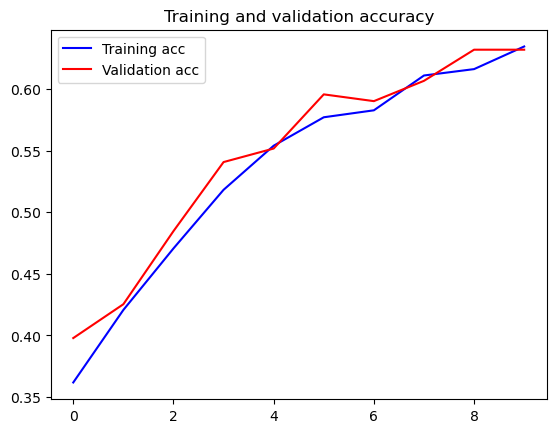

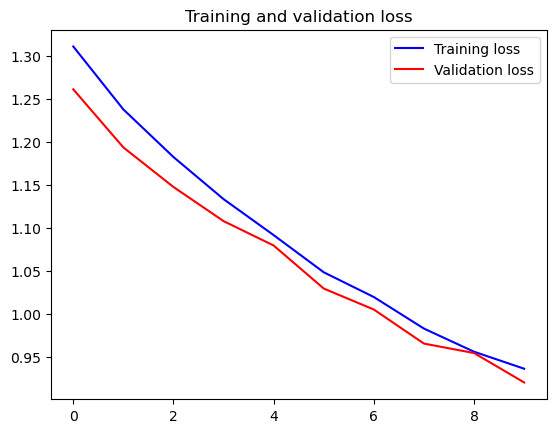

In [51]:
""" tanh activation function """
custom_model = Sequential([ 
                            Conv2D(12,3, input_shape=(224, 224, 3), activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Flatten(),
                            Dropout(0.5),
                            Dense(1024, activation='tanh'),
                            Dense(64, activation='tanh'),
                            Dense(4, activation='softmax')
                            ])
# Configure the model for training
custom_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
print("Fit model on training data")
history=custom_model.fit(X_train, y_train, batch_size=128,
                         validation_data=(X_test, y_test), 
                         epochs=10, verbose=1) #for more info
custom_model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    return_dict=False
    )
visualize_results(history)

Fit model on training data
Epoch 1/10


2023-01-09 20:38:07.961338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3117 - acc: 0.3613

2023-01-09 20:38:15.491128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 9s 463ms/step - loss: 1.3117 - acc: 0.3613 - val_loss: 1.1916 - val_acc: 0.4319
Epoch 2/10
17/17 [==============================] - 6s 344ms/step - loss: 1.1290 - acc: 0.5059 - val_loss: 1.0896 - val_acc: 0.5615
Epoch 3/10
17/17 [==============================] - 6s 345ms/step - loss: 0.9834 - acc: 0.6039 - val_loss: 0.9062 - val_acc: 0.6319
Epoch 4/10
17/17 [==============================] - 6s 334ms/step - loss: 0.9010 - acc: 0.6444 - val_loss: 0.8486 - val_acc: 0.6484
Epoch 5/10
17/17 [==============================] - 6s 338ms/step - loss: 0.8573 - acc: 0.6524 - val_loss: 0.8336 - val_acc: 0.6747
Epoch 6/10
17/17 [==============================] - 7s 399ms/step - loss: 0.8230 - acc: 0.6722 - val_loss: 0.7910 - val_acc: 0.6626
Epoch 7/10
17/17 [==============================] - 6s 351ms/step - loss: 0.8210 - acc: 0.6693 - val_loss: 0.8271 - val_acc: 0.6451
Epoch 8/10
17/17 [==============================] - 6s 341ms/step - loss: 0.7778 - acc:

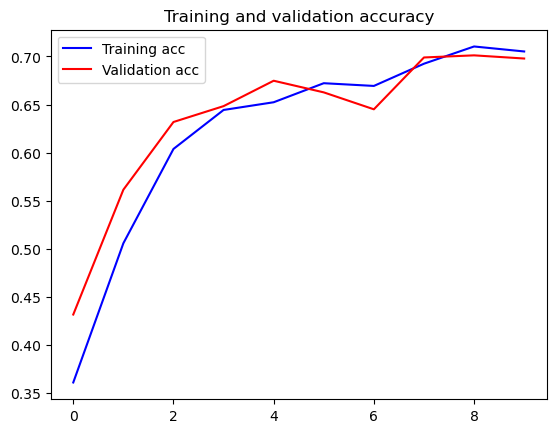

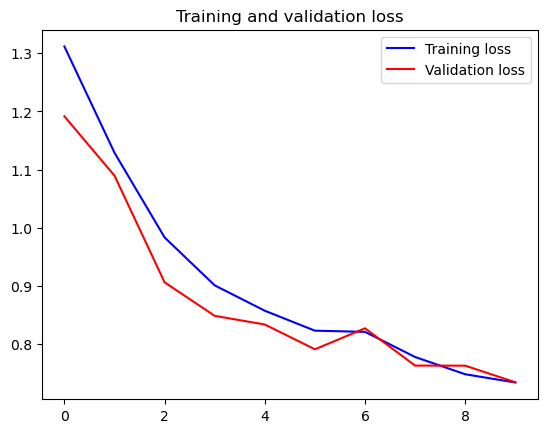

In [52]:
""" Different learning rate """
custom_model = Sequential([ 
                            Conv2D(12,3, input_shape=(224, 224, 3), activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Flatten(),
                            Dropout(0.5),
                            Dense(1024, activation='tanh'),
                            Dense(64, activation='tanh'),
                            Dense(4, activation='softmax')
                            ])
# Configure the model for training
custom_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=5e-4),
              metrics=['acc'])
print("Fit model on training data")
history=custom_model.fit(X_train, y_train, batch_size=128,
                         validation_data=(X_test, y_test), 
                         epochs=10, verbose=1) #for more info
custom_model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    return_dict=False
    )
visualize_results(history)

Fit model on training data
Epoch 1/10


2023-01-09 21:14:09.743572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3070 - acc: 0.3820

2023-01-09 21:14:17.736851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 10s 459ms/step - loss: 1.3070 - acc: 0.3820 - val_loss: 1.1787 - val_acc: 0.4440
Epoch 2/10
17/17 [==============================] - 6s 369ms/step - loss: 1.0742 - acc: 0.5407 - val_loss: 0.9686 - val_acc: 0.5912
Epoch 3/10
17/17 [==============================] - 6s 349ms/step - loss: 0.9783 - acc: 0.5959 - val_loss: 0.9178 - val_acc: 0.5967
Epoch 4/10
17/17 [==============================] - 6s 337ms/step - loss: 0.9197 - acc: 0.6194 - val_loss: 0.8559 - val_acc: 0.6615
Epoch 5/10
17/17 [==============================] - 6s 341ms/step - loss: 0.8590 - acc: 0.6458 - val_loss: 0.8478 - val_acc: 0.6593
Epoch 6/10
17/17 [==============================] - 6s 330ms/step - loss: 0.8419 - acc: 0.6665 - val_loss: 0.8279 - val_acc: 0.6923
Epoch 7/10
17/17 [==============================] - 6s 332ms/step - loss: 0.8078 - acc: 0.6759 - val_loss: 0.7861 - val_acc: 0.6956
Epoch 8/10
17/17 [==============================] - 6s 338ms/step - loss: 0.7945 - acc

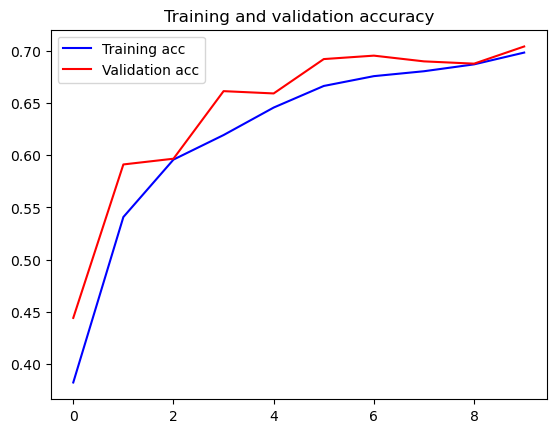

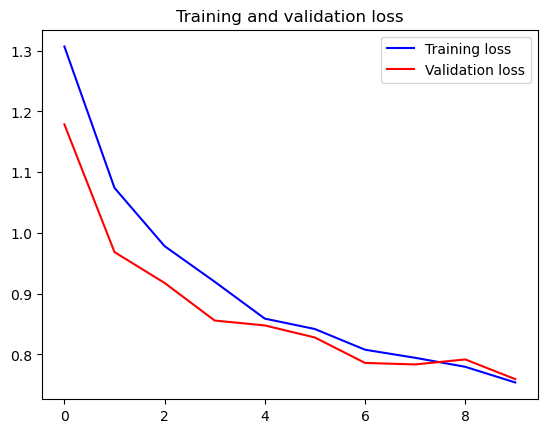

In [58]:
""" More nodes in layers """
custom_model = Sequential([ 
                            Conv2D(12,3, input_shape=(224, 224, 3), activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Flatten(),
                            Dropout(0.5),
                            Dense(1024, activation='tanh'),
                            Dense(128, activation='tanh'),
                            Dense(4, activation='softmax')
                            ])
# Configure the model for training
custom_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=5e-4),
              metrics=['acc'])
print("Fit model on training data")
history=custom_model.fit(X_train, y_train, batch_size=128,
                         validation_data=(X_test, y_test), 
                         epochs=10, verbose=1) #for more info
custom_model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    return_dict=False
    )
visualize_results(history)

Fit model on training data
Epoch 1/10


2023-01-09 21:24:07.296992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3318 - acc: 0.3391

2023-01-09 21:24:15.801371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 10s 518ms/step - loss: 1.3318 - acc: 0.3391 - val_loss: 1.2481 - val_acc: 0.3703
Epoch 2/10
17/17 [==============================] - 7s 383ms/step - loss: 1.1859 - acc: 0.4988 - val_loss: 1.0711 - val_acc: 0.5813
Epoch 3/10
17/17 [==============================] - 7s 390ms/step - loss: 1.0101 - acc: 0.6072 - val_loss: 0.8713 - val_acc: 0.6725
Epoch 4/10
17/17 [==============================] - 6s 374ms/step - loss: 0.8871 - acc: 0.6486 - val_loss: 0.8306 - val_acc: 0.6769
Epoch 5/10
17/17 [==============================] - 6s 384ms/step - loss: 0.8283 - acc: 0.6703 - val_loss: 0.7587 - val_acc: 0.7132
Epoch 6/10
17/17 [==============================] - 6s 375ms/step - loss: 0.7702 - acc: 0.7009 - val_loss: 0.7914 - val_acc: 0.6637
Epoch 7/10
17/17 [==============================] - 6s 385ms/step - loss: 0.7595 - acc: 0.7103 - val_loss: 0.8046 - val_acc: 0.6538
Epoch 8/10
17/17 [==============================] - 6s 385ms/step - loss: 0.7316 - acc

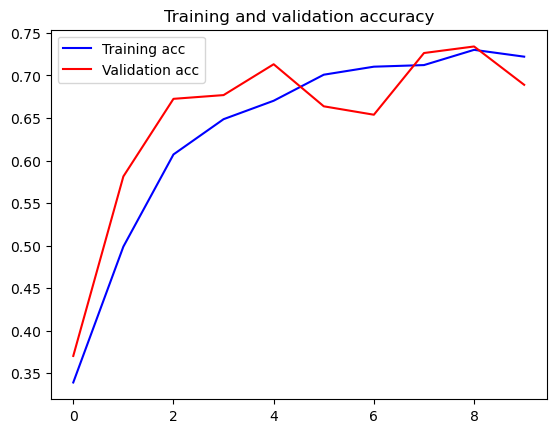

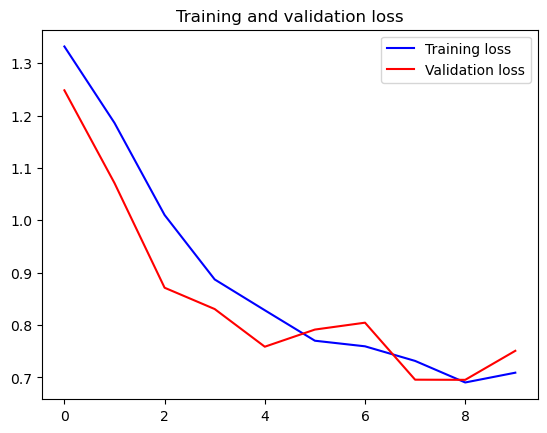

In [63]:
""" More filters in conv2d """
custom_model = Sequential([ 
                            Conv2D(15,3, input_shape=(224, 224, 3), activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(15,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(15,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(15,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(15,3, activation='relu'),
                            MaxPooling2D(2),
                            Flatten(),
                            Dropout(0.5),
                            Dense(1024, activation='tanh'),
                            Dense(64, activation='tanh'),
                            Dense(4, activation='softmax')
                            ])
# Configure the model for training
custom_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=5e-4),
              metrics=['acc'])
print("Fit model on training data")
history=custom_model.fit(X_train, y_train, batch_size=128,
                         validation_data=(X_test, y_test), 
                         epochs=10, verbose=1) #for more info
custom_model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    return_dict=False
    )
visualize_results(history)

Fit model on training data
Epoch 1/10


2023-01-09 21:26:10.310291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.3611 - acc: 0.3118

2023-01-09 21:26:25.729507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 24s 954ms/step - loss: 1.3611 - acc: 0.3118 - val_loss: 1.3257 - val_acc: 0.3000
Epoch 2/10
17/17 [==============================] - 12s 711ms/step - loss: 1.2626 - acc: 0.4178 - val_loss: 1.1686 - val_acc: 0.4846
Epoch 3/10
17/17 [==============================] - 12s 729ms/step - loss: 1.1382 - acc: 0.4993 - val_loss: 1.0463 - val_acc: 0.5165
Epoch 4/10
17/17 [==============================] - 12s 712ms/step - loss: 1.0562 - acc: 0.5271 - val_loss: 1.0281 - val_acc: 0.5286
Epoch 5/10
17/17 [==============================] - 12s 725ms/step - loss: 1.0190 - acc: 0.5464 - val_loss: 1.0897 - val_acc: 0.5286
Epoch 6/10
17/17 [==============================] - 12s 711ms/step - loss: 0.9863 - acc: 0.5648 - val_loss: 1.1347 - val_acc: 0.5143
Epoch 7/10
17/17 [==============================] - 12s 721ms/step - loss: 0.9793 - acc: 0.5657 - val_loss: 0.9573 - val_acc: 0.5824
Epoch 8/10
17/17 [==============================] - 12s 725ms/step - loss: 0.959

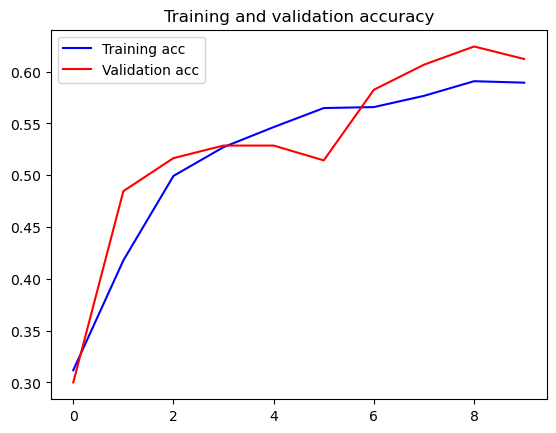

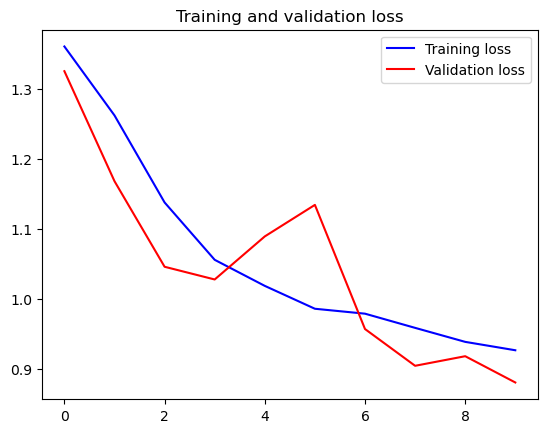

In [64]:
""" More conv2d layers """
custom_model = Sequential([ 
                            Conv2D(12,3, input_shape=(224, 224, 3), activation='relu'),
                            Conv2D(12,3, activation='relu'),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Flatten(),
                            Dropout(0.5),
                            Dense(1024, activation='tanh'),
                            Dense(64, activation='tanh'),
                            Dense(4, activation='softmax')
                            ])
# Configure the model for training
custom_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=5e-4),
              metrics=['acc'])
print("Fit model on training data")
history=custom_model.fit(X_train, y_train, batch_size=128,
                         validation_data=(X_test, y_test), 
                         epochs=10, verbose=1) #for more info
custom_model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    return_dict=False
    )
visualize_results(history)

Fit model on training data
Epoch 1/150


2023-01-09 21:32:21.217563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.2978 - acc: 0.3768

2023-01-09 21:32:30.056458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 11s 481ms/step - loss: 1.2978 - acc: 0.3768 - val_loss: 1.1999 - val_acc: 0.3890
Epoch 2/150
17/17 [==============================] - 6s 371ms/step - loss: 1.0997 - acc: 0.5285 - val_loss: 1.0192 - val_acc: 0.5813
Epoch 3/150
17/17 [==============================] - 6s 340ms/step - loss: 0.9784 - acc: 0.6114 - val_loss: 0.9392 - val_acc: 0.6121
Epoch 4/150
17/17 [==============================] - 6s 338ms/step - loss: 0.8852 - acc: 0.6491 - val_loss: 0.8899 - val_acc: 0.6396
Epoch 5/150
17/17 [==============================] - 6s 345ms/step - loss: 0.8442 - acc: 0.6660 - val_loss: 0.8792 - val_acc: 0.6593
Epoch 6/150
17/17 [==============================] - 6s 341ms/step - loss: 0.8045 - acc: 0.6858 - val_loss: 0.8853 - val_acc: 0.6297
Epoch 7/150
17/17 [==============================] - 6s 343ms/step - loss: 0.7742 - acc: 0.7009 - val_loss: 0.7701 - val_acc: 0.6956
Epoch 8/150
17/17 [==============================] - 6s 337ms/step - loss: 0.732

17/17 [==============================] - 6s 337ms/step - loss: 0.2216 - acc: 0.9228 - val_loss: 0.6569 - val_acc: 0.8077
Epoch 124/150
17/17 [==============================] - 6s 342ms/step - loss: 0.2312 - acc: 0.9185 - val_loss: 0.6162 - val_acc: 0.8088
Epoch 125/150
17/17 [==============================] - 6s 342ms/step - loss: 0.2363 - acc: 0.9143 - val_loss: 0.6649 - val_acc: 0.8000
Epoch 126/150
17/17 [==============================] - 6s 338ms/step - loss: 0.2264 - acc: 0.9176 - val_loss: 0.5671 - val_acc: 0.8154
Epoch 127/150
17/17 [==============================] - 6s 338ms/step - loss: 0.2357 - acc: 0.9199 - val_loss: 0.5695 - val_acc: 0.8176
Epoch 128/150
17/17 [==============================] - 6s 332ms/step - loss: 0.2273 - acc: 0.9195 - val_loss: 0.6690 - val_acc: 0.7978
Epoch 129/150
17/17 [==============================] - 6s 335ms/step - loss: 0.2361 - acc: 0.9195 - val_loss: 0.5404 - val_acc: 0.8330
Epoch 130/150
17/17 [==============================] - 6s 332ms/step 

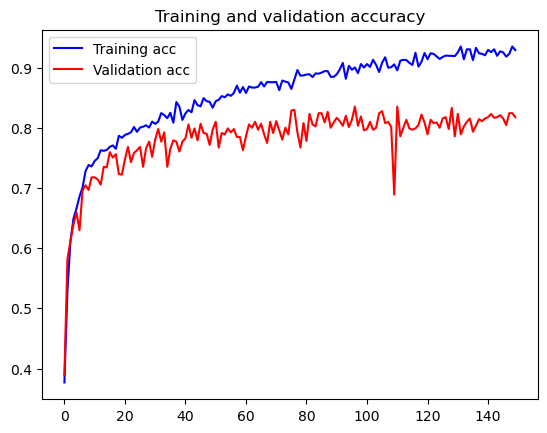

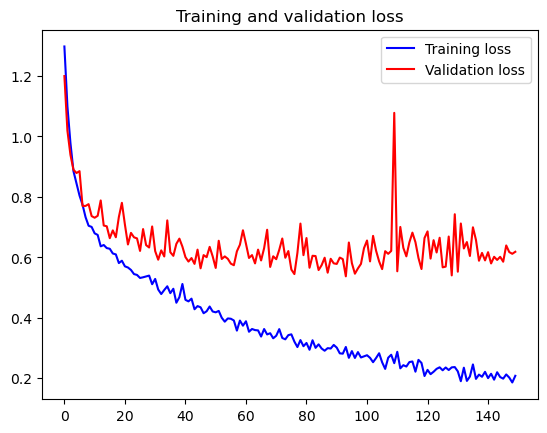

In [65]:
""" optimal solution with 150 epochs """
custom_model = Sequential([ 
                            Conv2D(12,3, input_shape=(224, 224, 3), activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(12,3, activation='relu'),
                            MaxPooling2D(2),
                            Flatten(),
                            Dropout(0.5),
                            Dense(1024, activation='tanh'),
                            Dense(64, activation='tanh'),
                            Dense(4, activation='softmax')
                            ])
# Configure the model for training
custom_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=5e-4),
              metrics=['acc'])
print("Fit model on training data")
history=custom_model.fit(X_train, y_train, batch_size=128,
                         validation_data=(X_test, y_test), 
                         epochs=150, verbose=1) #for more info
custom_model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    return_dict=False
    )
visualize_results(history)

In [ ]:
""" last attempt trying to get close to the shape of vgg models """
custom_model = Sequential([ 
                            Conv2D(30,3, input_shape=(224, 224, 3), activation='relu'),
                            Conv2D(30,3, activation='relu'),
                            Conv2D(30,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(30,3, activation='relu'),
                            Conv2D(30,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(30,3, activation='relu'),
                            Conv2D(30,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(30,3, activation='relu'),
                            Conv2D(30,3, activation='relu'),
                            MaxPooling2D(2),
                            Conv2D(15,3, activation='relu'),
                            Conv2D(15,3, activation='relu'),
                            MaxPooling2D(2),
                            Flatten(),
                            Dropout(0.5),
                            Dense(1024, activation='tanh'),
                            Dense(64, activation='tanh'),
                            Dense(4, activation='softmax')
                            ])
# Configure the model for training
custom_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=5e-4),
              metrics=['acc'])
print("Fit model on training data")
history=custom_model.fit(X_train, y_train, batch_size=128,
                         validation_data=(X_test, y_test), 
                         epochs=150, verbose=1) #for more info
custom_model.evaluate(
    x=X_train,
    y=y_train,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    return_dict=False
    )
visualize_results(history)